In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspect = inspect(engine)
inspect.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

C:\Users\michal\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


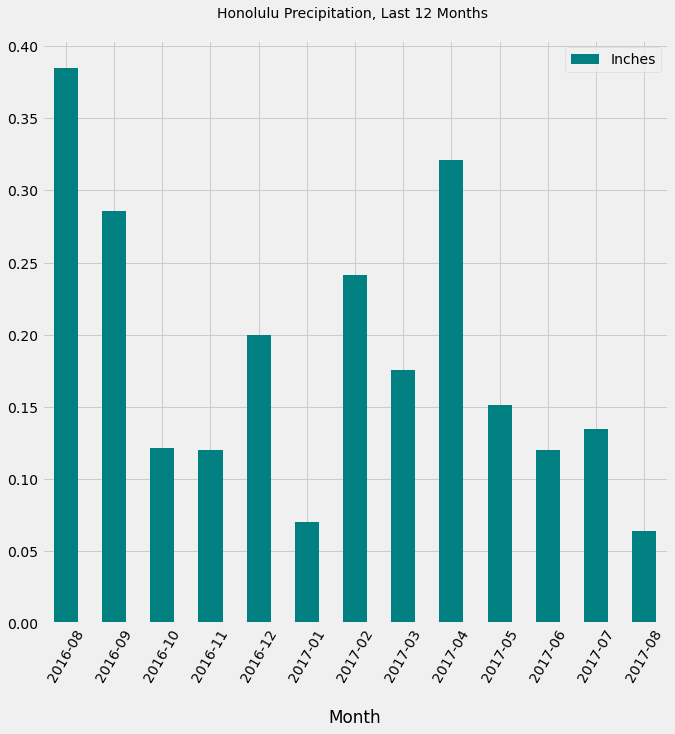

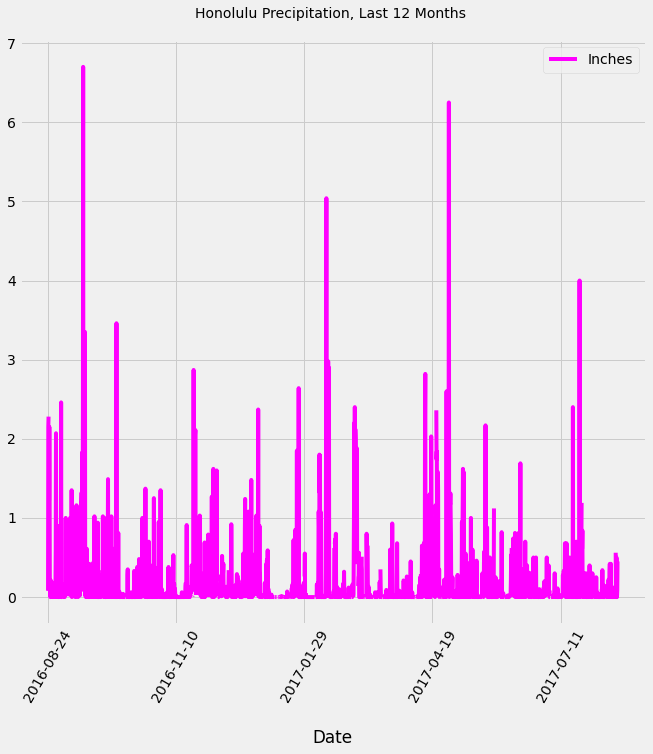

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
last_date
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
daily_precipitation = session.query(func.strftime(measurement.date),measurement.prcp).\
filter(measurement.date > year_ago).order_by(measurement.date).all()
daily_precipitation

# # Since daily precipitation is difficult to see patterns in, and makes for an unwieldy bar chart, 
# get monthly averages:
avg_mon_precipitation = session.query(func.strftime('%Y-%m', measurement.date),func.avg(measurement.prcp)).\
filter(measurement.date > year_ago).group_by(func.strftime('%Y-%m', measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

avg_precipitation_df = pd.DataFrame(avg_mon_precipitation, columns=['Month','Inches'])
precip_df=pd.DataFrame(daily_precipitation, columns=['Day','Inches'])
# # Use Pandas Plotting with Matplotlib to plot the data
avg_precipitation_df.plot(kind='bar', x='Month', y='Inches', color = 'teal', figsize= (10,10))
plt.xlabel('\nMonth')
plt.xticks(rotation=60)
plt.title("Honolulu Precipitation, Last 12 Months \n",fontsize=14)
plt.savefig("Images/avg_precip.png",bbox_inches='tight')

precip_df.plot(x='Day',y ='Inches', color='magenta', figsize=(10,10))
plt.xticks(rotation=60)
plt.xlabel('\nDate')
plt.title("Honolulu Precipitation, Last 12 Months \n",fontsize=14)
plt.savefig("Images/precipitation.png",bbox_inches='tight')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
daily_precipitation_df = pd.DataFrame(daily_precipitation, columns = ['Date','Inches'])

daily_precipitation_df[["Inches"]].describe()

,Inches
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
inspect.get_columns('station')
session.query(func.count(station.station)).all()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
    
sel = [measurement.station, func.count(measurement.date),station.id]
joined_data = session.query(*sel).filter(measurement.station==station.station).group_by(station.station).\
order_by(func.count(measurement.date).desc()).all()
joined_data


[('USC00519281', 2772, 7),
 ('USC00519397', 2724, 1),
 ('USC00513117', 2709, 2),
 ('USC00519523', 2669, 6),
 ('USC00516128', 2612, 9),
 ('USC00514830', 2202, 3),
 ('USC00511918', 1979, 8),
 ('USC00517948', 1372, 4),
 ('USC00518838', 511, 5)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station, func.count(measurement.date),station.id]
most_active = session.query(*sel).filter(measurement.station==station.station).group_by(station.station).\
order_by(func.count(measurement.date).desc()).first()

sel=[station.id,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
overview_data = session.query(*sel).filter(measurement.station==station.station).filter(station.id==most_active[2]).all()

for record in overview_data:
    (station_id, min_tem, max_tem, avg_tem) = record
    print(f'''For station #{station_id}, the lowest temperature ever recorded was {round(min_tem)}. 
The highest temperature was {round(max_tem)}, and the average temperature is {round(avg_tem)}.''')


For station #7, the lowest temperature ever recorded was 54. 
The highest temperature was 85, and the average temperature is 72.


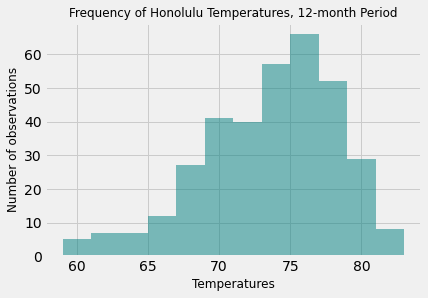

In [29]:
# Choose the station with the highest number of temperature observations.
session.query(measurement.station,func.count(measurement.tobs)).group_by(measurement.station).\
order_by(func.count(measurement.tobs)).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(measurement.tobs).filter(measurement.station=='USC00519281').\
filter(measurement.date > year_ago).all()

# unpack the values in year_temps so they can be transferred to the plot
temps_for_plot = [record[0] for record in year_temps]
temps_df=pd.DataFrame(temps_for_plot,columns=['temps'])

# # Make the histogram

x = temps_df['temps']
num_bins = 12
plt.hist(x, num_bins, facecolor='teal', alpha=0.5)
plt.title("Frequency of Honolulu Temperatures, 12-month Period",fontsize=12)
plt.xlabel('Temperatures', fontsize=12)
plt.ylabel('Number of observations', fontsize=12)
plt.savefig("Images/station-histogram.png",bbox_inches='tight')

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """

    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vac_temps = []
for record in calc_temps('2016-12-1','2016-12-14'):
    (min, avg, max) = record
    vac_temps.append(record)
    
vac_temps

[(65.0, 69.625, 78.0)]

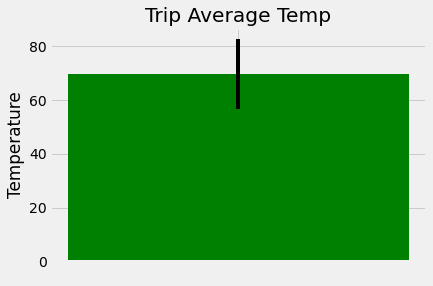

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peyak (tmax-tmin) value as the y error bar (yerr)
php_elements = []
for tuple in vac_temps:
    php_elements.append(tuple[0])
    php_elements.append(tuple[1])
    php_elements.append(tuple[2])
    
php = php_elements[2] - php_elements[0]
avg_temp = php_elements[1]

x = np.arange(1)
y = avg_temp

plt.bar(x,y, color='green', yerr=php, align='center')
plt.xticks(x, " ")
plt.ylabel("Temperature")
plt.title("Trip Average Temp")

plt.savefig("Images/temperature.png",bbox_inches='tight')



In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session=Session(engine)

results = session.query(func.sum(measurement.prcp), station.station, station.name, station.latitude, station.longitude,\
station.elevation).filter(measurement.station==station.station).filter(measurement.date >= dt.date(2016, 12, 7)).filter(measurement.date\
< dt.date(2016, 12, 15)).group_by(station.station).order_by(func.sum(measurement.prcp).desc()).all()

rainfall_totals = []
for total, station, name, lat, long, elev in results:
    rain_dict = {}
    rain_dict['Total Rainfall'] = total
    rain_dict['Station'] = station
    rain_dict['Station Name'] = name
    rain_dict['Latitude'] = lat
    rain_dict['Longitude'] = long
    rain_dict['Elevation'] = elev
    rainfall_totals.append(rain_dict)
    
rainfall_totals

[{'Total Rainfall': 1.48,
  'Station': 'USC00519281',
  'Station Name': 'WAIHEE 837.5, HI US',
  'Latitude': 21.45167,
  'Longitude': -157.84888999999998,
  'Elevation': 32.9},
 {'Total Rainfall': 1.07,
  'Station': 'USC00516128',
  'Station Name': 'MANOA LYON ARBO 785.2, HI US',
  'Latitude': 21.3331,
  'Longitude': -157.8025,
  'Elevation': 152.4},
 {'Total Rainfall': 0.7400000000000001,
  'Station': 'USC00514830',
  'Station Name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'Latitude': 21.5213,
  'Longitude': -157.8374,
  'Elevation': 7.0},
 {'Total Rainfall': 0.7400000000000001,
  'Station': 'USC00513117',
  'Station Name': 'KANEOHE 838.1, HI US',
  'Latitude': 21.4234,
  'Longitude': -157.8015,
  'Elevation': 14.6},
 {'Total Rainfall': 0.7300000000000002,
  'Station': 'USC00519397',
  'Station Name': 'WAIKIKI 717.2, HI US',
  'Latitude': 21.2716,
  'Longitude': -157.8168,
  'Elevation': 3.0},
 {'Total Rainfall': 0.34,
  'Station': 'USC00519523',
  'Station Name': 'WAIMANALO EXPER

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip

def daily_normals_range(date, date2):
    sel = [func.strftime("%m-%d", measurement.date),func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) >= date).filter(func.strftime("%m-%d", measurement.date)\
    <=date2).group_by(func.strftime("%m-%d", measurement.date)).all()

normals = daily_normals_range("12-01", "12-14")
normals 
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[('12-01', 65.0, 71.91666666666667, 78.0),
 ('12-02', 62.0, 71.32692307692308, 77.0),
 ('12-03', 67.0, 72.88679245283019, 79.0),
 ('12-04', 66.0, 72.17647058823529, 81.0),
 ('12-05', 64.0, 70.92156862745098, 78.0),
 ('12-06', 61.0, 69.3921568627451, 78.0),
 ('12-07', 58.0, 69.2, 79.0),
 ('12-08', 60.0, 70.27450980392157, 83.0),
 ('12-09', 64.0, 71.90196078431373, 80.0),
 ('12-10', 61.0, 71.24528301886792, 78.0),
 ('12-11', 64.0, 72.38775510204081, 78.0),
 ('12-12', 64.0, 70.88235294117646, 79.0),
 ('12-13', 65.0, 70.9423076923077, 80.0),
 ('12-14', 65.0, 71.18, 78.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_data = []
for date,min,avg,max in normals:
    normals_dict = {}
    normals_dict['Mon-Day'] = date
    normals_dict['Low Temp'] = min
    normals_dict['Avg Temp'] = avg
    normals_dict['High Temp'] = max
    normals_data.append(normals_dict)
    
normals_data

normals_df = pd.DataFrame(normals_data, columns=['Mon-Day','Low Temp', 'Avg Temp', 'High Temp']).set_index('Mon-Day')
normals_df.head(14)


,Low Temp,Avg Temp,High Temp
Mon-Day,,,
12-01,65.0,71.916667,78.0
12-02,62.0,71.326923,77.0
12-03,67.0,72.886792,79.0
12-04,66.0,72.176471,81.0
12-05,64.0,70.921569,78.0
12-06,61.0,69.392157,78.0
12-07,58.0,69.200000,79.0
12-08,60.0,70.274510,83.0
12-09,64.0,71.901961,80.0


C:\Users\michal\anaconda3\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


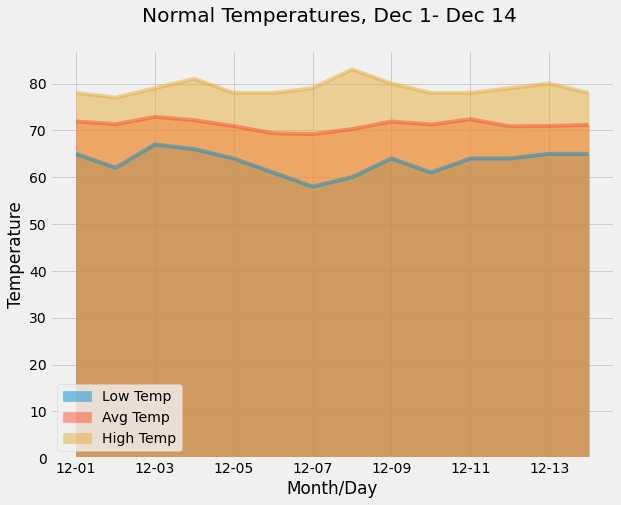

In [49]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind='area', stacked=False, figsize=(9,7))
plt.xlabel('Month/Day')
plt.ylabel('Temperature')
plt.title('Normal Temperatures, Dec 1- Dec 14 \n')

plt.savefig("Images/daily_normals.png",bbox_inches='tight')